In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from utils import create_directory
from plot import plot_learning

In [2]:
# set the directory name same as you used for running the model.py
# it will save the data in your Documents/Data/directory_name folder
# here i used directory_name = 'try1' as the name
data_dir = create_directory(directory_name='try14')

Directory '/Users/mahdiyar/Documents/Data/MotorNet/try14' already exists.


Text(0, 0.5, 'Angle loss in degree')

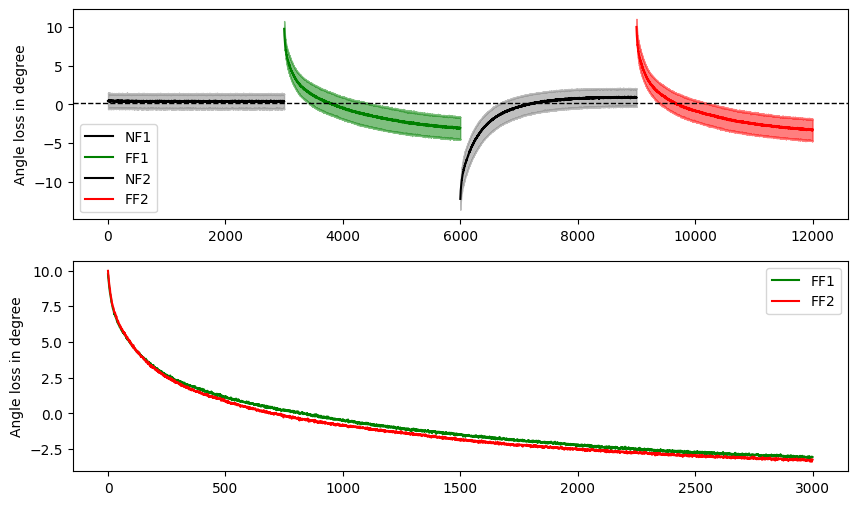

In [3]:
fig, ax = plot_learning(data_dir,num_model=16,w=1,loss_type='angle_loss',figsize=(10,6))
#ax[0].axhline(y=0.0138, color='k', linestyle='--', linewidth=1)
ax[0].axhline(y=0.2, color='k', linestyle='--', linewidth=1)
ax[0].set_ylabel('Angle loss in degree')
ax[1].set_ylabel('Angle loss in degree')
#fig.savefig(os.path.join(data_dir,'learning_curve_al.png'),dpi=300)

Text(0, 0.5, 'position loss [m]')

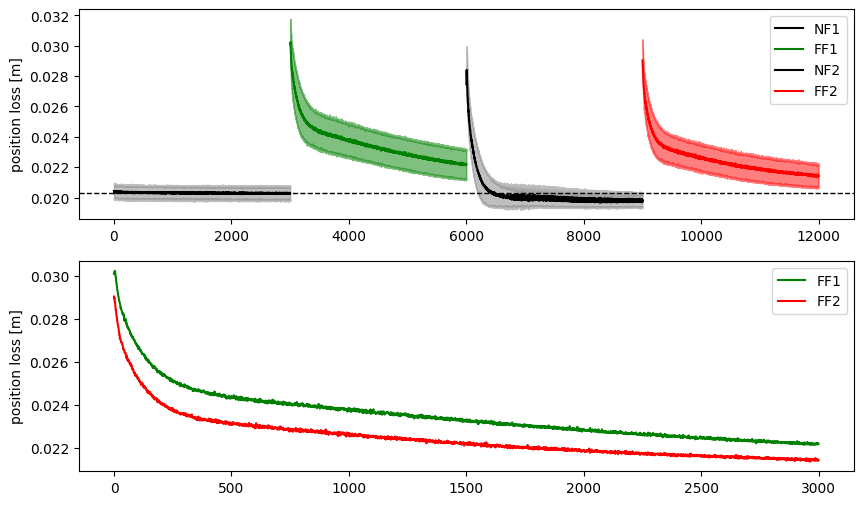

In [4]:
fig, ax = plot_learning(data_dir,num_model=16,w=1,loss_type='position_loss',figsize=(10,6))
ax[0].axhline(y=0.0203, color='k', linestyle='--', linewidth=1)
#ax[0].axhline(y=7.20, color='k', linestyle='--', linewidth=1)
ax[0].set_ylabel('position loss [m]')
ax[1].set_ylabel('position loss [m]')
#fig.savefig(os.path.join(data_dir,'learning_curve_al.png'),dpi=300)

In [ ]:
fig, ax = plot_learning(data_dir,num_model=16,w=1,loss_type='p_loss',figsize=(10,6))
ax[0].axhline(y=0.0203, color='k', linestyle='--', linewidth=1)
#ax[0].axhline(y=7.20, color='k', linestyle='--', linewidth=1)
ax[0].set_ylabel('position loss [m]')
ax[1].set_ylabel('position loss [m]')
#fig.savefig(os.path.join(data_dir,'learning_curve_al.png'),dpi=300)